# Schätzrisiken in der Portfoliotheorie

Die folgende Darstellung ist angelehnt an: 

- Kempf, A./Memmel, C. *Schätzrisiken in der Portfoliotheorie*. In: Kleeberg, J.M. & Rehkugler, H. (Hrsg.): Handbuch Portfoliomanagement, 2. Auflage, Bad Soden/Ts. 2002, S. 895-919.
- Memmel, C. *Schätzrisiken in der Portfoliotheorie: Auswirkungen und Möglichkeiten der Reduktion,* Eul Verlag, Lohmar, 2004.


## Einleitung

In seinem bahnbrechenden *Journal of Finance* Artikel "Portfolio Selection" aus dem Jahr 1952 legt **Harry Markowitz** dar, dass risikoaverse Investoren sich bei ihrer Anlageentscheidung an Erwartungswert und Varianz der Rendite ihres Gesamtportfolios orientieren sollten. Der Anleger strebt danach, eine vorgegebene erwartete Portfoliorendite mit dem geringsten Risiko zu erreichen. Die mathematische Formalisierung dieser Idee führt zu einem quadratischen Optimierungsproblem mit N-1 Entscheidungsparametern, wobei N die Anzahl der zulässigen Anlageinstrumente darstellt. 

Die praktische Implementierung des Portfolioansatzes von Markowitz ist mit einem zentralen Problem verbunden. Der Anleger kennt die Parameter der Renditeverteilungen (Erwartungswerte, Varianzen, Kovarianzen) nicht. Diese Parameter können beispielsweise aus den fundamentalen Unternehmensdaten ermittelt werden oder - und darauf werden wir uns konzentrieren - aus historischen Zeitreihen geschätzt werden. Diese Schätzung stellt für große Wertpapierportfolios zunächst in quantitativer Hinsicht eine Hausforderung dar, da N erwartete Renditen und Varianzen bzw. 0,5 · N · (N-1) Kovarianzen zu schätzen sind. Selbst wenn das Anlageuniversum eines Investors nur aus 500 Aktien besteht, sind bereits 125.750 Parameter zu schätzen. Neben diesem reinen Mengenproblem besteht allerdings ein zweites gravierenderes Problem, das im Zentrum der folgenden Ausführungen stehen wird. Jede Schätzung ist mit einem Schätzrisiko verbunden, d.h., der geschätzte Parameter wird im allgemeinen nicht dem (unbeobachtbaren) wahren Parameter der Renditeverteilung entsprechen. Dies kann zu suboptimalen Portfoliozusammensetzungen und damit zu mangelndem Anlageerfolg führen. Das Ziel dieses Notebooks besteht darin, die Bedeutung des Schätzrisikos für die Portfoliozusammensetzung aufzuzeigen und anschließend Wege darzustellen, wie der Einfluss des Schätzrisikos auf die Portfoliozusammensetzung verringert werden kann. 


## Einfluß des Schätzfehlers auf die Portfoliozusammensetzung

Zunächst werden wir in einer kleinen Simulationsstudie aufzeigen, wie stark das Schätzrisiko die Portfoliozusammensetzung beeinflusst. Hierzu simulieren wir für vier Aktien unabhängig identisch normalverteilte Wochenrenditen über einen Zeitraum von zwei Jahren. Für jede Aktie unterstellen wir einen Erwartungswert der Rendite von 11% p.a. und eine Standardabweichung von 25% p.a. Außerdem nehmen wir an, dass die Renditen der verschiedenen Aktien paarweise eine Korrelation von 0,3 aufweisen. Daneben unterstellen wir, dass es ein risikoloses Instrument mit einer Rendite $r_f$ = 6% p.a. gibt. Dieses risikolose Instrument berücksichtigen wir, damit die 
optimale Zusammensetzung des Aktienportfolios unabhangig vom Ausmaß der Risikoaversion des Anlegers ist (Tobin-Separation). Tobin (1958) hat gezeigt, dass alle Anleger in diesem Fall unabhängig von dem Ausmaß ihrer Risikoaversion das gleiche Aktienportfolio halten, das sogenannte Tangentialportfolio.

Um die Größenordnung der Schätzrisiken zu verdeutlichen, analysieren wir die optimale Zusammensetzung des Tangentialportfolios eines Anlegers in zwei Fällen. Im ersten Fall kennt der Anleger die obigen Verteilungsparameter, während er sie im zweiten Fall aus den simulierten Renditerealisationen schätzen muss. Kennt der Anleger die Verteilungsparameter, so ist es für ihn optimal, sein in Aktien anzulegendes Vermögen gleichmäßig auf die vier Aktien zu verteilen. Diese Gleichverteilungsstrategie führt zu einer erwarteten Aktienportfoliorendite von 11% p.a. bei einer Standardabweichung von 17,23% p.a. Betrachten wir nun den Fall, dass der Anleger die Verteilungsparameter aus den realisierten Renditen schätzt.


In [1]:
# import of necessary libaries
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

**Ausgangssituation für die Simulation**:

- wahre Parameter (annualisiert): $\mu_i=0,11, \sigma_i=0,25, \rho_{ij}=0,3$, für $i,j =1,..., 4,$ und $i \neq j$. 

- Die Varianz auf Wochenebene beträgt: $0,25^{2}/52=0,00120192$.

- Für die wöchentliche erwartete Rendite gilt: $0,11/52=0,00211538$.

- Der konstante Korrelationskoeffizient ist 0,3. Damit folgt für die wöchentliche Kovarianz: $0,25^{2}/52 * 0,3=0,00036058$. 

In [2]:
# Die wöchentliche Varianz-Kovarianzmatrix nennen wir *Sigma_true*:
Sigma_true=[[0.00120192, 0.00036058, 0.00036058, 0.00036058],\
            [0.00036058, 0.00120192, 0.00036058, 0.00036058],\
            [0.00036058, 0.00036058, 0.00120192, 0.00036058],\
            [0.00036058, 0.00036058, 0.00036058, 0.00120192]]

# Der Vektor der erwarteten, wöchentlichen Renditen:
means_true=[0.00211538, 0.00211538, 0.00211538, 0.00211538]


In [3]:
# eine Monte Carlo Ziehung mit jeweils einer 2-jährigen Zeitreihe 
# (104 Wochen) für jede Aktie
np.random.seed(42)
df = pd.DataFrame(np.asarray(np.random.multivariate_normal(means_true,\
                Sigma_true, size = 104)), columns=['A1', 'A2', 'A3', 'A4'])
means_est = df.mean().values * 52 # annualsiert
Sigma_est = df.cov().values * 52 # annualisiert
std_est=np.sqrt(np.diag(Sigma_est))

In den folgenden zwei Tabellen sind die geschätzten Parameter eines exemplarischen Zufallspfades der Simulation sowie die wahren Werte angegeben. Zunächst ein Vergleich der wahren und geschätzen erwarteten Renditen: 

In [4]:
pd.DataFrame({'wahr': 0.11, 'geschätzt': means_est, \
              'Schätzfehler (%)': (0.11-means_est)*100}, index=df.columns)

,wahr,geschätzt,Schätzfehler (%)
A1,0.11,0.193280,-8.328017
A2,0.11,0.214416,-10.441623
A3,0.11,0.099346,1.065403
A4,0.11,0.145107,-3.510683


Und nun der Vergleich der wahren (0,25) und der geschätzten Standardabweichung:

In [5]:
pd.DataFrame({'wahr': 0.25, 'geschätzt': std_est, \
              'Schätzfehler (%)': (0.25-std_est)*100}\
             , index=df.columns)

,wahr,geschätzt,Schätzfehler (%)
A1,0.25,0.233158,1.684243
A2,0.25,0.226982,2.301796
A3,0.25,0.236087,1.391323
A4,0.25,0.239289,1.071104


Berechnen wir nun die optimalen Gewichte für das Tangentialportfolio, d.h., das Portfolio mit der maximalen Sharpe Ratio. Wir setzen als Nebenbedingung nur die Budget-Restriktion: kein Leverage (Fremdkapitalaufnahme), Summe der Portfoliogewichte entspricht 1.  

In [6]:
# function that implements the Sharpe portfolio optimization
# with no short sale constraint!

# definition of target function for maximum Sharpe portfolio
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', constraints=constraints,tol=1e-10)
    weights=[round(x,4) for x in result['x']]
    return weights

In [7]:
weights=max_sharpe_ratio(means_est, Sigma_est, 0.06)

Graphischer Vergleich der optimalen Portfoliogewichte: tatsächlich (1/N) versus ermittelt auf Basis geschätzter Input-Parameter: 

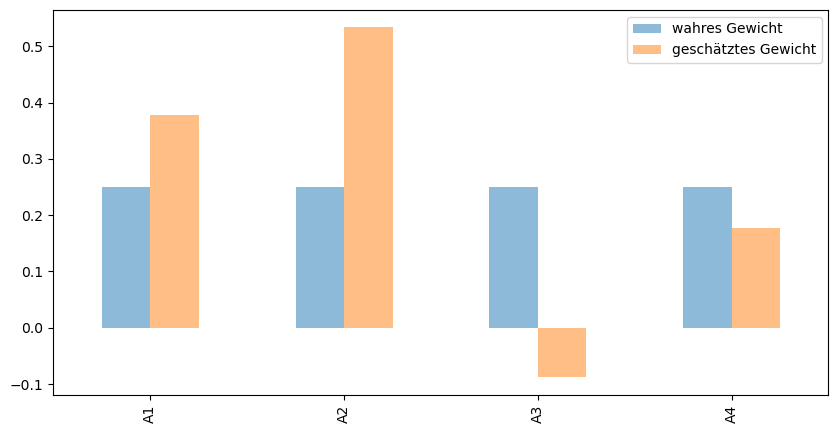

In [8]:
pd.DataFrame({'wahres Gewicht': 0.25, 'geschätztes Gewicht': weights},index=df.columns). \
plot.bar(stacked=False, alpha=0.5, figsize=(10,5));

Zwei Ergebnisse fallen auf. Das erste bemerkenswerte Ergebnis besteht darin, dass sich die optimalen Gewichte auf Basis der geschätzten Parameter sehr stark von den wahren optimalen Werten unterscheiden. Offensichtlich schlagen sich Schätzfehler gravierend in der Portfoliozusammensetzung nieder. Daneben weichen die Schätzwerte für die erwartete Rendite sehr stark von deren wahren Wert ab, während die Schätzwerte der Standardabweichung wesentlich näher am wahren Parameter liegen. Dies ist ein erster Hinweis darauf, dass die Schätzung der erwarteten Rendite die größten Schwierigkeiten verursacht. Diesem Hinweis gehen wir im folgenden Abschnitt weiter nach. 

## Komponenten des Schätzfehlers

Bisher haben wir den Einfluss des gesamten Schätzfehlers auf die Portfoliozusammensetzung herausgearbeitet, ohne allerdings der Frage nachzugehen, welche Quelle des Schätzfehlers (Fehlschätzung bei erwarteten Renditen, Fehlschätzung bei Varianzen, Fehlschätzung bei Korrelationen) sich besonders stark auf die Portfoliogewichte durchschlägt. Die Stärke des Einflusses hängt hierbei von zwei Größen ab, der Sensitivität der Portfoliozusammensetzung auf die Fehlschätzung und dem Ausmaß der Fehlschätzung. Im folgenden werden wir zunächst die Sensitivität der Portfoliozusammensetzung für die verschiedenen Komponenten des Schätzfehlers analysieren und anschließend Fragen nach der erreichbaren Schätzgenauigkeit für die verschiedenen Parameter diskutieren. 

###  Sensitivitat des optimalen Portfolios bezüglich Schätzfehlern in den verschiedenen Parametern 

Zur Analyse der Sensitivitat der Portfoliogewichte in bezug auf Fehlschätzungen in den einzelnen Parametern verwenden wir wiederum die vier Aktien des Abschnittes 1 mit den wahren Parametern $\mu_i$ = 11% (erwartete Rendite), $\sigma_i$ = 25% (Standardabweichung) und $rho_{ij}$ = 30% (Korrelationskoeffizient). Als Vergleichsmaßstab betrachten 
wir den Fall, das der Anleger sämtliche Parameter exakt kennt und sein optimales Aktienportfolio deshalb aus gleichen Anteilen in allen vier Aktien besteht. Hiermit werden drei Fälle verglichen, in denen der Anleger einen Schätzfehler bezüglich der Parameter der Aktie 1 begeht. Im ersten Fall täuscht er sich bei der erwarteten Rendite der Aktie 1, im zweiten Fall bei der Standardabweichung der Aktie 1 und im dritten Fall bei der Korrelation zwischen den Renditen von Aktie 1 und Aktie 2. Die einzelnen Fälle zur Bestimmung der Komponenten des Schatzrisikos sind in der nachfolgenden Tabelle dargestellt. 

![](figure31.png)

Wir untersuchen den Einfluß des Schätzfehlers, indem wir in einer komparativ-statischen Analyse den jeweiligen mit Schätzfehler versehenen Parameter ausgehend vom wahren Wert um ±10 Prozentpunkten in Schritten der Größe 2,0 Prozentpunkte variieren. Die erwartete Rendite bewegt sich somit im Wertebereich zwischen 1% und 21%, die Volatilitat zwischen 15% und 35% und die Korrelation zwischen 20% und 40%. Für die verschiedenen Parameterkonstellationen bestimmen wir die optimale Portfoliozusammensetzung und vergleichen diese mit der optimalen Portfoliozusammensetzung bei Kenntnis aller Parameter.

**Fall 1: Schätzfehler in der erwarteten Rendite von Aktie 1, zwischen 1% und 21% um den wahren Wert 11%.**

In [9]:
# Berechnung der Fehlgewichtung in A1 für Fehler in der geschätzten
# erwarteten Rendite
est_error_mean=np.linspace(0.01, 0.21, 11) # symmetrische Fehler um wahren Wert 11%
wa1_means=np.zeros(11) # enthält die optimierten Gewichte
for i in range(11):
    means_mod=np.multiply(means_true,52) # annualisieren nicht vergessen!
    Sigma_true_ann=np.multiply(Sigma_true,52) # annualisieren nicht vergessen!
    means_mod[0]=est_error_mean[i]
    weights=max_sharpe_ratio(means_mod, Sigma_true_ann, 0.06)
    wa1_means[i]=weights[0]
    

**Fall 2: Schätzfehler in der Standardabweichung der Rendite von Aktie 1, zwischen 15% und 35% um den wahren Wert 25%.**


In [10]:
# Berechnung der Fehlgewichtung in A1 für Fehler in der geschätzten
# (annualisierten) Standardabweichung
est_error_std=np.linspace(0.15, 0.35, 11) # symmetrische Fehler um wahren Wert 25%
# Berechnung der neuen Varianz und der Kovarianz
a1_var=np.zeros(11) # enthält die neue Varianz
a1_cov=np.zeros(11) # enthält die neue Kovarianz
wa1_std=np.zeros(11) # enthält die optimierten Gewichte

for i in range(11):
    a1_var[i]=est_error_std[i]**2
    a1_cov[i]=est_error_std[i]*0.25*0.3
    # Berechnung der neuen Varanz-Kovarianzmatrix; 7 Änderungen vornehmen
    Sigma_true_ann=np.multiply(Sigma_true,52) # annualisieren nicht vergessen!
    Sigma_mod=Sigma_true_ann
    Sigma_mod[0,0]=a1_var[i]
    Sigma_mod[0,1]=a1_cov[i]
    Sigma_mod[0,2]=a1_cov[i]
    Sigma_mod[0,3]=a1_cov[i]
    Sigma_mod[1,0]=a1_cov[i]
    Sigma_mod[2,0]=a1_cov[i]
    Sigma_mod[3,0]=a1_cov[i]
    means_ann=np.multiply(means_true,52) # annualisieren nicht vergessen!
    weights=max_sharpe_ratio(means_ann, Sigma_mod, 0.06)
    wa1_std[i]=weights[0]
   

**Fall 3: Schätzfehler in der Korrelation der Rendite von Aktie 1, zwischen 20% und 40% um den wahren Wert 30%.**

In [11]:
# Berechnung der Fehlgewichtung in A1 für Fehler in der geschätzten
# Korrelation zwischen Aktie 1 und 2
est_error_corr=np.linspace(0.20, 0.40, 11) # symmetrische Fehler um wahren Wert 25%
# Berechnung der neuen Kovarianz
a1_cov=np.zeros(11) # enthält die neue Kovarianz
wa1_corr=np.zeros(11) # enthält die optimierten Gewichte

for i in range(11):
    a1_cov[i]=est_error_corr[i]*0.25*0.25
    # Berechnung der neuen Varanz-Kovarianzmatrix; 2 Änderungen vornehmen
    Sigma_true_ann=np.multiply(Sigma_true,52) # annualisieren nicht vergessen!
    Sigma_mod=Sigma_true_ann
    Sigma_mod[0,1]=a1_cov[i]
    Sigma_mod[1,0]=a1_cov[i]
    means_ann=np.multiply(means_true,52) # annualisieren nicht vergessen!
    weights=max_sharpe_ratio(means_ann, Sigma_mod, 0.06)
    wa1_corr[i]=weights[0]
   

Die folgende Tabelle gibt die optimalen Gewichte für Aktie 1 für die verschiedenen Fälle an. 

In [12]:
df=pd.DataFrame({'1. Fall': np.round(wa1_means,2), '2. Fall': np.round(wa1_std,2), \
              '3. Fall': np.round(wa1_corr,2)}\
             , index=np.linspace(-10, 10, 11)).T
df.columns.name='Abweichungen vom wahren Parameterwert in (%)'
df

Abweichungen vom wahren Parameterwert in (%),-10.0,-8.0,-6.0,-4.0,-2.0,0.0,2.0,4.0,6.0,8.0,10.0
1. Fall,-1.79,-1.11,-0.62,-0.26,0.02,0.25,0.44,0.59,0.72,0.83,0.93
2. Fall,0.66,0.56,0.47,0.38,0.31,0.25,0.20,0.16,0.12,0.09,0.07
3. Fall,0.27,0.27,0.26,0.26,0.25,0.25,0.25,0.24,0.24,0.24,0.23


In der Tabelle ist klar zu erkennen, dass sich Änderungen der erwarteten Rendite am stärksten auf die Portfoliozusammensetzung durchschlagen. Wird beispielsweise die erwartete Rendite von Aktie 1 um 6 Prozentpunkte überschätzt, so ergibt sich hierdurch ein optimales Gewicht für Aktie 1 in Höhe von 0,72. Im Vergleich zum optimalen Gewicht ohne Schätzfehler bedeutet dies eine Übergewichtung der Aktie 1 um 47 Prozentpunkte. Eine Fehlschätzung der Standardabweichung in gleicher Höhe schlägt sich demgegenüber wesentlich weniger stark (-0,13 = 0,12 - 0,25) auf die Portfoliozusammensetzung durch, und eine Fehlschätzung der Korrelation besitzt keinen nennenswerten Einfluss (-0,01 = 0,24 - 0,25). Dies wird anhand der nachfolgenden Abbildung nochmals verdeutlicht. Dort ist die Über- oder Untergewichtung von Aktie 1 in Abhängigkeit der Stärke des Schätzfehlers graphisch dargestellt. 

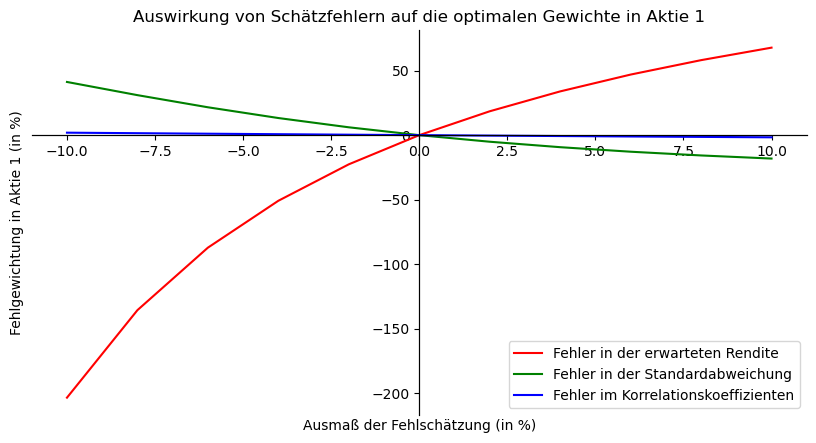

In [13]:
fig1 = plt.figure(num=1, facecolor='w', figsize=(10, 5))
ax = fig1.add_subplot(111)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_position('zero')
ax.spines['top'].set_position('zero')

ax.spines['bottom'].set_position('zero')
plt.plot(np.linspace(-10, 10, 11), (wa1_means-0.25)*100, 'r-', label='Fehler in der erwarteten Rendite')
plt.plot(np.linspace(-10, 10, 11), (wa1_std-0.25)*100, 'g-', label='Fehler in der Standardabweichung')
plt.plot(np.linspace(-10, 10, 11), (wa1_corr-0.25)*100, 'b-', label='Fehler im Korrelationskoeffizienten')

plt.legend(loc=4,  frameon=True)
plt.xlabel('Ausmaß der Fehlschätzung (in %)')
ax.yaxis.set_label_coords(-0.01,0.75)
ax.xaxis.set_label_coords(0.5,-0.01)

plt.ylabel('Fehlgewichtung in Aktie 1 (in %)')
plt.title('Auswirkung von Schätzfehlern auf die optimalen Gewichte in Aktie 1')
plt.show()

Die Abbildung zeigt deutlich, dass bereits kleine Fehler in den Parameterschätzungen zu erheblichen Änderungen bei den optimierten Gewichten führen. Dies gilt im besonderen für Schätzfehler bei den erwarteten Renditen. Die Sensitivität der Portfoliozusammensetzung auf Schätzfehler ist somit ein zentrales Problem bei der Anwendung des Portfolioansatzes von Markowitz. Wie stark ein Anleger allerdings hierdurch berührt ist, hängt außer von der Sensitivität von der erzielbaren Genauigkeit bei der Schätzung der verschiedenen Parameter ab. Wie groß die Schätzgenauigkeit für die verschiedenen Parameter ist, wird im folgenden analysiert. 

### Größe der Schätzfehler für die verschiedenen Parameter 

Aus historischen Daten sollen möglichst verläßliche Schätzwerte für die erwartete annualisierte Rendite $(\mu_i)$ und die annualisierte Standardabweichung $(\sigma_i)$ ermittelt werden. (Auf eine Analyse für die Korrelation verzichten wir im folgenden, da - wie oben berichtet - die Sensitivität der Portfoliozusammensetzung auf Fehlschätzungen der Korrelation sehr gering ist.) Hierzu stehe eine Zeitreihe zur Verfügung, die n (nicht annualisierte) Periodenrenditen $r_{t,i}$ enthält, welche unabhängig, identisch und normalverteilt seien. Ihre Verteilung ist durch den Erwartungswert $\mu_i\Delta t$ und die Varianz $\sigma^2_i\Delta t$ charakterisiert. Um den Schätzfehler zu reduzieren, wird der Anleger versuchen, die Anzahl der Beobachtungen, die in seine Schätzung eingehen, zu erhöhen. Dies kann er dadurch erreichen, dass er den Schätzzeitraum $T$ (gemessen in Jahren) verlängert oder den Schätzzeitraum in kürzere Teilintervalle einteilt, also $\Delta t$ verkürzt. 

Aus verschiedenen Gründen ist einem Anleger jedoch die Verlängerung des Beobachtungszeitraums $T$ häufig nicht möglich. Bei jungen Unternehmen liegt keine lange Kurshistorie vor. Andere Unternehmen weisen zwar eine längere Kurshistorie auf, jedoch sind diese durch Brüche gekennzeichnet, die durch Umstrukturierungen oder Unternehmenszukäufe verursacht sind. Schließlich ist gegen die Verwendung einer sehr langen Kurshistorie einzuwenden, dass die Renditeparameter nicht über Jahrzehnte konstant bleiben. Dagegen genießt der Anleger bei der Wahl der Länge der Teilintervalle größere Freiheiten. Er kann von Jahresdaten auf Quartals-, Monats-, Wochen-, Tagesdaten oder gar innertägliche Daten wechseln, um so die Anzahl der Beobachtungen zu erhöhen. Im folgenden wollen wir prüfen, wie sich dies auf die Qualität des Schätzers für die erwartete Rendite und die Varianz niederschlägt. Hierzu müssen wir zunächst eine Annahme treffen, welche Schätzer der Anleger verwendet. Wir unterstellen, dass er wiederum die einfache historisch basierte Schätzung verwendet, also das arithmetische Mittel für das erste Verteilungsmoment. Unter Verwendung der Tatsache, dass die Schätzperiode $T$ sich ergibt als die Anzahl der Subperioden n multipliziert mit deren Länge $\Delta t$, lässt sich der Mittelwert-Schätzer schreiben als: 

$$ (1)\quad \hat{\mu_i}=\frac{1}{\Delta t}\frac{1}{n}\sum_{t=1}^{n}r_{t,i}=\frac{1}{T}\sum_{t=1}^{n}r_{t,i}.$$

Dieser Schätzer ist erwartungstreu, d.h., er trifft im Mittel den wahren Parameterwert $\mu_i$. Die Varianz des Schätzers ist ein Maß für dessen Güte. Je geringer die Varianz ist, um so weniger streut der Schätzer um den wahren Parameterwert. Die Varianz des Schätzers beträgt: 

$$ (2)\quad var(\hat{\mu_i})=\frac{\sigma^2_i}{T}.$$

Bemerkenswerterweise hängt dieses Gütemaß bei gleichbleibendem Beobachtungszeitraum $T$ nicht von der Datenfrequenz ab. Dies bedeutet, dass eine Erhöhung der Beobachtungsfrequenz nicht zu genaueren Schätzergebnissen führt. Daneben fällt auf, dass der Schätzfehler im Verhältnis zu der zu schätzenden Größe sehr groß ist. Dies kann man sich verdeutlichen, wenn man erneut die Daten aus unserem Beispiel in Abschnitt 1 verwendet. Die erwartete Rendite einer Aktie beträgt 11% p.a. und die Standardabweichung der Rendite 25% p.a. In der folgenden Tabelle wird die Breite eines 95%-Konfidenzintervalls in Abhängigkeit der Länge des Schätzzeitraums $T$ dargestellt. Allgemein lautet die Formel zur Längenberechnung des (asymptotischen) $(1-\alpha)$-Konfidenzintervalls:

$$ (3)\quad 2\cdot[Q_{1-\frac{\alpha}{2}}\cdot\frac{\sigma_i}{\sqrt{T}}].$$

Hierbei bezeichnet $Q_{1-\frac{\alpha}{2}}$ das $(1-\frac{\alpha}{2})$-Quantil der Standardnormalverteilung. Für $\alpha=5\%$ gilt: $Q_{97,5}=1,96$

In [14]:
# Länge des Schätzzeitraums T in Jahren
est_period=[1, 5, 10, 20, 50]
# Breite des Konfidenzintervalls
confidence=np.zeros(5)
for i in range(5):
    confidence[i]=round((2*1.96*0.25/np.sqrt(est_period[i]))*100, 2)
pd.DataFrame({'Schätzzeitraum T in Jahren': est_period, \
              'Breite des Konfidenzintervalls (%)': confidence})    

,Schätzzeitraum T in Jahren,Breite des Konfidenzintervalls (%)
0,1,98.00
1,5,43.83
2,10,30.99
3,20,21.91
4,50,13.86


Selbst bei einem Schätzzeitraum von 10 Jahren beträgt die Breite dieses Intervalls noch mehr als 30 Prozentpunkte. Dies bedeutet, dass mit einer Wahrscheinlichkeit von 95% der Schätzfehler nicht mehr als 15,5 Prozentpunkte beträgt, der Schätzwert also im Intervall [-4,5%;+26,5%] liegt. Wie wir aber oben gezeigt haben, besitzt bereits eine deutlich geringere Fehlschätzung einen dramatischen Einfluß auf die Portfoliozusammensetzung. 

Nun wenden wir uns dem Schätzwert für die Varianz zu. Unter Verwendung der definitorischen Beziehung $T = n \cdot \Delta t$ lässt sich der einfache historisch basierte Schätzer schreiben als: 

$$ (4)\quad \hat{\sigma}^2_i=\frac{1}{T-\Delta t}\sum_{t=1}^{n}(r_{t,i}-\hat{\mu_i}\Delta t)^2.$$

Die asymptotische Varianz dieses Schätzers beträgt (siehe Memmel, 2004, S. 33): 

$$ (5)\quad var(\hat{\sigma}^2_i)=\frac{2\sigma^4_i\Delta t}{T}.$$

Die Güte des Varianzschätzers lässt sich somit bei gegebenem Schätzzeitraum $T$ durch eine Erhöhung der Datenfrequenz (Verkleinerung von $\Delta t$) verbessern. So verdreifacht sich beispielsweise durch Übergang von Quartalsdaten auf Monatsdaten die Anzahl der Beobachtungen, und der Schätzfehler reduziert sich ungefähr auf ein Drittel des ursprünglichen Wertes.

Die asymptotische Varianz des Schätzers für die Renditestandardabweichung lässt sich bestimmen als :

$$ (6)\quad var(\hat{\sigma}_i)=\frac{1}{2}\sigma^2_i\frac{\Delta t}{T}.$$

In der folgenden Tabelle sind die Breiten des 95%-Konfidenzintervalles (in %) für den Schätzer der Standardabweichung der annualisierten Renditen für verschiedene Längen der Schätzperioden und verschiedene Datenfrequenzen aufgeführt. 

In [15]:
# Länge des Schätzzeitraums T in Jahren
est_period=[1, 5, 10, 20, 50]
# Breite des Konfidenzintervalls
confidence_daily=np.zeros(5) # delta_t=1/250
confidence_weekly=np.zeros(5) # delta_t=1/52
confidence_monthly=np.zeros(5) # delta_t=1/12
confidence_quarterly=np.zeros(5) # delta_t=1/4

for i in range(5):
    confidence_daily[i]=round(2*1.96*np.sqrt(0.25**2/ \
                    (2*est_period[i]*250))*100, 2)
    confidence_weekly[i]=round(2*1.96*np.sqrt(0.25**2/ \
                    (2*est_period[i]*52))*100, 2)
    confidence_monthly[i]=round(2*1.96*np.sqrt(0.25**2/ \
                    (2*est_period[i]*12))*100, 2)
    confidence_quarterly[i]=round(2*1.96*np.sqrt(0.25**2/ \
                    (2*est_period[i]*4))*100, 2)
Zeitraum=['T=1 Jahr', 'T=5 Jahre', 'T=10 Jahre', 'T=20 Jahre', 'T=50 Jahre']    
pd.DataFrame({'Tagesdaten': confidence_daily, 'Wochendaten': confidence_weekly,\
              'Monatsdaten': confidence_monthly, 'Quartalsdaten': confidence_quarterly},\
             index=Zeitraum) 


,Tagesdaten,Wochendaten,Monatsdaten,Quartalsdaten
T=1 Jahr,4.38,9.61,20.00,34.65
T=5 Jahre,1.96,4.30,8.95,15.50
T=10 Jahre,1.39,3.04,6.33,10.96
T=20 Jahre,0.98,2.15,4.47,7.75
T=50 Jahre,0.62,1.36,2.83,4.90


Im Vergleich mit der vorherigen Tabelle fällt auf, dass die Standardabweichung wesentlich genauer geschätzt werden kann als die erwartete Rendite. Dies gilt c.p. um so stärker, je größer die Datenfrequenz ist. So kann unter Verwendung von Tagesdaten bereits bei einer Schätzperiode von einem Jahr eine recht präzise Varianzschätzung vorgenommen werden, während für diese Frist die erwartete Rendite nur mit einer hohen Ungenauigkeit geschätzt werden kann. 
Die bisher gewonnenen Ergebnisse scheinen damit zu implizieren, dass ein Anleger bei gegebener Schätzperiode eine möglichst hohe Datenfrequenz wählen sollte, da er hierdurch gemäß (5) den Schätzfehler in der Varianz verringert und den Schätzfehler in der erwarteten Rendite unbeeinflußt läßt. Dieser Aussage ist allerdings nicht uneingeschränkt zuzustimmen. Eine sehr hohe Datenfrequenz bringt in der Praxis nämlich das Problem mit sich, dass die empirisch beobachteten Renditen nicht mehr unabhängig, identisch und normalverteilt sind. So findet man beispielsweise, dass Aktienrenditen bei einer hohen Datenfrequenz (bspw. Tagesdaten) Autokorrelation aufweisen und ihre Verteilung zu viel Masse in den Enden aufweist. 

Zusammenfassend kann man damit festhalten: Die Schätzung der erwarteten Renditen verursacht wesentlich größere Probleme als die Schätzung der Renditevarianz. Die Schätzung der erwarteten Renditen kann nämlich nicht durch eine Erhohung der Datenfrequenz verbessert werden, während eine höhere Datenfrequenz zu besseren Schätzungen der Renditevarianz führt. Da außerdem die Portfoliozusammensetzung wesentlich sensitiver auf Fehlschätzungen in den erwarteten Renditen als in den Varianzen reagiert, muss konstatiert werden, dass Schätzfehler in erwarteten Renditen das zentrale Problem bei der Implementierung des Markowitz-Modells darstellen. Deshalb konzentrieren wir uns im folgenden ausschließlich auf Schätzfehler in den erwarteten Renditen und unterstellen, dass die zweiten Momente der Verteilung (Varianzen, Korrelationen) dem Anleger bekannt sind. 


## Lösungsansätze für das Schätzproblem

In den bisherigen Abschnitten haben wir herausgearbeitet, warum die traditionelle Umsetzung der Portfoliotheorie Probleme aufwirft. Erwartete Renditen lassen sich mit dem traditionellen Schätzansatz des arithmetischen Mittels nur sehr ungenau schätzen. Dies führt typischerweise zu extremen und suboptimalen Portfoliogewichten.

Grundsätzlich bieten sich mehrere Möglichkeiten an, dieses Problems Herr zu werden. Eine erste Möglichkeit besteht darin, ein ökonomisch fundiertes Modell zu entwickeln, aus dem sich endogen die optimalen Portfoliogewichte ergeben und das es erlaubt, auf leichter zu ermittelnde Größen anstelle der erwarteten Renditen zurückzugreifen. Ein Beispiel hierfür stellt das CAPM dar, bei dem die optimalen Portfoliogewichte den anteiligen Marktkapitalisierungen entsprechen. 

Eine zweite Möglichkeit, den Einfluss von Schätzfehlern und die daraus resultierenden extremen Portfoliogewichte zu reduzieren, besteht darin, **exogene Schranken (Constraints)** für die erwarteten Renditen bzw. die Portfoliogewichte vorzugeben. Den ersten Ansatz wählt Merton (1980), der unterstellt, dass die wahren erwarteten Renditen in einer Welt mit risikoaversen Anlegern nicht negativ sein können und gleichzeitig einen bestimmten Höchstwert nicht überschreiten sollten. Ein einfaches Beispiel für exogene Schranken bezüglich der Portfoliogewichte - diese sind bereits Bestandteil der Originalarbeit von Markowitz - besteht im Verbot von Leerverkaufen. Hierdurch werden die Portfoliogewichte in jeder Aktie auf den Bereich [0%; 100%] restringiert. Die optimale Strategie besteht hierbei häufig aus Randlösungen, d.h., in den meisten Fällen konzentriert sich das Anlagevolumen auf wenige Aktien, die sich in der jüngsten Vergangenheit besonders gut entwickelt haben (Winner-Strategie). Hierdurch geht Diverifikationspotential innerhalb des Portfolios verloren. Um diesem Mißstand abzuhelfen, werden z.B. im Rahmen der relativen (Index- oder Benchmark-basierten) Optimierung die Abweichungen der Portfolioanteile von den Gewichten eines Index- oder Benchmarkportfolios begrenzt. Als Folge der erzwungenen, aber nicht optimalen Diversifikation reduziert sich zwar das Portfoliorisiko, doch leidet gleichzeitig die Wertentwicklung dieses Portfolios.

Die dritte Möglichkeit besteht darin, gänzlich auf die Schätzung von erwarteten Renditen zu verzichten. So könnte ein Anleger beispielsweise das **global varianzminimale Aktienportfolio** oder ein **gleichgewichtetes Portfolio** wählen. Diese Portfoliozusammensetzung muss als *heuristisch* bezeichnet werden, da sie sich nicht aus einem allgemeinen Markowitz-Ansatz ergibt. Trotzdem haben verschiedene empirische Studien (z.B. DeMiguel et al., 2009) ergeben, dass mit diesen Strategien bessere Ergebnisse erzielt werden können als mit der traditionellen Umsetzung der Portfoliotheorie. 

Neben diesen klassischen heuristischen Ansätzen haben sich seit der Finanzkrise 2008-2009 zunehmend risikogesteuerte Ansätze etabliert. Die Portfoliobildung basiert auch hier allein auf Volatilitäts- und Korrelationsannahmen und die Diversifikation wird in den Mittelpunkt gestellt. Prognosen erwarteter Renditen spielen keine Rolle und werden nicht benötigt. Drei Methoden einer risikogesteuerten Portfoliokonstruktion werden unterschieden: **Equal-Risk-Budget (ERB), Equal-Risk-Contribution (ERC)** und **Maximum-Diversification (MD)**, wobei die ersten Beiden als sogenannte **Risk Parity** Ansätze bezeichnet werden. Alle drei Ansätze sind methodisch eng verwandt. Im Grundsatz soll jederzeit mit vergleichbarem Risiko in alle Assetklassen investiert werden. Das Gewicht einer Assetklasse wird dabei reduziert, wenn ihre Volatilität oder ihre Korrelation zu einer anderen Assetklasse steigt.

Die vierte Möglichkeit zur Reduzierung des Einflusses von Schätzrisiken in den erwarteten Renditen besteht darin, den Schätzer für erwartete Renditen zu verbessern und diesen verbesserten Schätzwert dann als Inputvariable für die Portfoliooptimierung zu verwenden. Eine beliebte Klasse solcher verbesserter Schätzer sowohl für $\mu$ als auch $\Sigma$ stellen die sogenannten **geschrumpften Schätzer** dar. 

Die fünfte Möglichkeit besteht schließlich darin, (wie bei der vierten Möglichkeit) einen verbesserten Schätzer für die erwarteten Renditen zu verwenden, aber zusätzlich noch bei der Portfoliooptimierung die Existenz des verbleibenden Schätzrisikos zu berücksichtigen. In diesem Ansatz wird also explizit berücksichtigt, dass der Anleger zwei Arten von Risiken ausgesetzt ist, dem Renditeänderungsrisiko und dem Schätzrisiko. Zwei bekannte Vertreter dieses Ansatzes sind die **Portfolio-Resampling** Methode von Michaud und Michaud (2008), und das **Black/Litterman (BL)** Modell (siehe Black und Litterman, 1992). 

Die folgende Abbildung untergliedert noch einmal die oben skizzierten Lösungsansätze nach den zugrundeliegenden Ansatzpunkten.

![](figure32.png)

## Literatur

Black, F., Litterman R. (1992). Global Portfolio Optimization. Financial Analysts Journal (September-October), 28-43. 

DeMiguel, V., Garlappi, L., Uppa, R. (2009). Optimal Versus Naive Diversification: How Inefficient is the 1/N Portfolio Strategy? Review of Financial Studies 22, 1915-1953.  

Markowitz, H.M. (1952). Portfolio Selection. Journal of Finance 7, 77-91.

Merton, R.C. (1980). On Estimating the Expected Return on the Market: An Exploratory Investigation. Journal of Financial Economics 8, 323-361.

Michaud, R.O, Michaud, R.O., (2008). Efficient Asset Management: A Practical Guide to Stock Portfolio Optimization and Asset Allocation, 2nd Edition, Oxford University Press. 

Tobin, J. (1958). Liquidity Preference as Behaviour Towards Risk. Review of Economic Studies 25, 65-86.


